# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

### Обзор данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None #предотвращение появление сообщения SettingWithCopyWarning
pd.pandas.set_option('display.max_columns', None) #отобразим все колонки таблицы
pd.options.display.float_format = '{:,.2f}'.format #округлим числовые значения до сотых, дабы избержать экспоненциального формата данных
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["axes.formatter.limits"] = (-99, 99) #disable scientific notation on axes

Откроем файл с данными и изучим общую информацию.

In [ ]:
path = '/datasets/'
web_path = '****'
data_csv = 'real_estate_data.csv'

try:
    data_raw = pd.read_csv(path + data_csv)
except:
    data_raw = pd.read_csv(web_path + data_csv)

In [ ]:
data_raw.sample(5)

,total_images\tlast_price\ttotal_area\tfirst_day_exposition\trooms\tceiling_height\tfloors_total\tliving_area\tfloor\tis_apartment\tstudio\topen_plan\tkitchen_area\tbalcony\tlocality_name\tairports_nearest\tcityCenters_nearest\tparks_around3000\tparks_nearest\tponds_around3000\tponds_nearest\tdays_exposition
10390,18\t30000000.0\t137.0\t2018-08-07T00:00:00\t3\...
6374,1\t6100000.0\t79.0\t2016-05-19T00:00:00\t3\t3....
18102,20\t5850000.0\t75.0\t2017-11-16T00:00:00\t4\t2...
23383,1\t4950000.0\t72.0\t2016-07-02T00:00:00\t3\t\t...
6936,6\t3620000.0\t38.0\t2018-01-01T00:00:00\t1\t\t...


Данные склеились в одну строку вместо того, чтобы разбиться по колонкам. Это произошло из-за разделителя `\t` в формате csv.

Разделим строки на столбцы и приведем данные в нормальный вид, чтобы работать с ними в дальнейшем.

In [ ]:
try:
    data_raw = pd.read_csv(path + data_csv, sep='\t')
except:
    data_raw = pd.read_csv(web_path + data_csv, sep='\t')

Проверим нормально ли теперь открываются данные.

In [ ]:
data_raw.sample(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
22455,1,"11,615,600.00",81.80,2015-08-10T00:00:00,3,3.10,16.00,43.83,3,NaN,False,False,14.58,NaN,Санкт-Петербург,"37,434.00","8,460.00",1.00,441.00,2.00,427.00,"1,334.00"
6900,9,"1,550,000.00",50.00,2017-08-06T00:00:00,2,2.50,5.00,30.00,1,NaN,False,False,6.60,NaN,Кириши,NaN,NaN,NaN,NaN,NaN,NaN,352.00
14973,13,"5,589,000.00",59.30,2018-02-19T00:00:00,3,2.55,9.00,43.60,9,NaN,False,False,5.50,1.00,Санкт-Петербург,"10,874.00","12,814.00",0.00,NaN,0.00,NaN,50.00
10739,0,"4,100,000.00",41.00,2017-07-01T00:00:00,1,3.70,6.00,25.00,2,NaN,False,False,13.00,0.00,Санкт-Петербург,"20,074.00","3,147.00",2.00,575.00,3.00,56.00,33.00
14871,7,"3,400,000.00",44.10,2017-10-26T00:00:00,2,3.00,4.00,27.30,3,NaN,False,False,6.50,NaN,Санкт-Петербург,"18,314.00","17,316.00",1.00,633.00,0.00,NaN,78.00
1806,11,"3,380,000.00",35.00,2019-01-27T00:00:00,1,2.50,9.00,21.00,7,NaN,False,False,6.40,2.00,Красное Село,"25,531.00","28,956.00",3.00,195.00,0.00,NaN,NaN
21772,6,"2,449,000.00",57.00,2017-12-12T00:00:00,3,NaN,5.00,39.90,3,NaN,False,False,5.80,NaN,поселок городского типа Синявино,NaN,NaN,NaN,NaN,NaN,NaN,219.00
1722,6,"5,900,000.00",52.00,2015-11-19T00:00:00,2,NaN,10.00,31.00,3,NaN,False,False,9.50,2.00,Санкт-Петербург,"34,446.00","11,799.00",0.00,NaN,0.00,NaN,785.00
11063,0,"3,750,000.00",34.20,2016-06-28T00:00:00,1,2.58,9.00,15.40,9,NaN,False,False,8.60,0.00,Сестрорецк,"57,917.00","34,847.00",2.00,380.00,1.00,154.00,43.00
195,8,"5,300,000.00",60.00,2016-05-19T00:00:00,3,NaN,9.00,NaN,4,NaN,False,False,NaN,0.00,Санкт-Петербург,"52,072.00","17,061.00",1.00,"1,133.00",3.00,239.00,372.00


In [ ]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

23699 объявлений о продаже и 22 столбца с некоторыми параметрами/категориями, помимо этого можно заметить, что некоторые колонки имеют неверный тип данных.

| Column           | Dtype   | required_Dtype  | reason                                        |
|------------------|--------------|-----------------|------------------------------------------------|
| first_day_exposition  | object       | dateline           | Дата публикации объявления            |
| floors_total     | float64      | int64           | Этажи не могут быть вещественным числом |
| is_apartment     | object       | bool            | Судя по содержимому это булево значение, т.е. недвижимость является данной категорий, либо нет                  |
| balcony          | float64      | int64           | Число балконов должно быть целым                   |
| days_exposition  | float64      | int64           | Количество дней публикации не может быть вещественным числом |

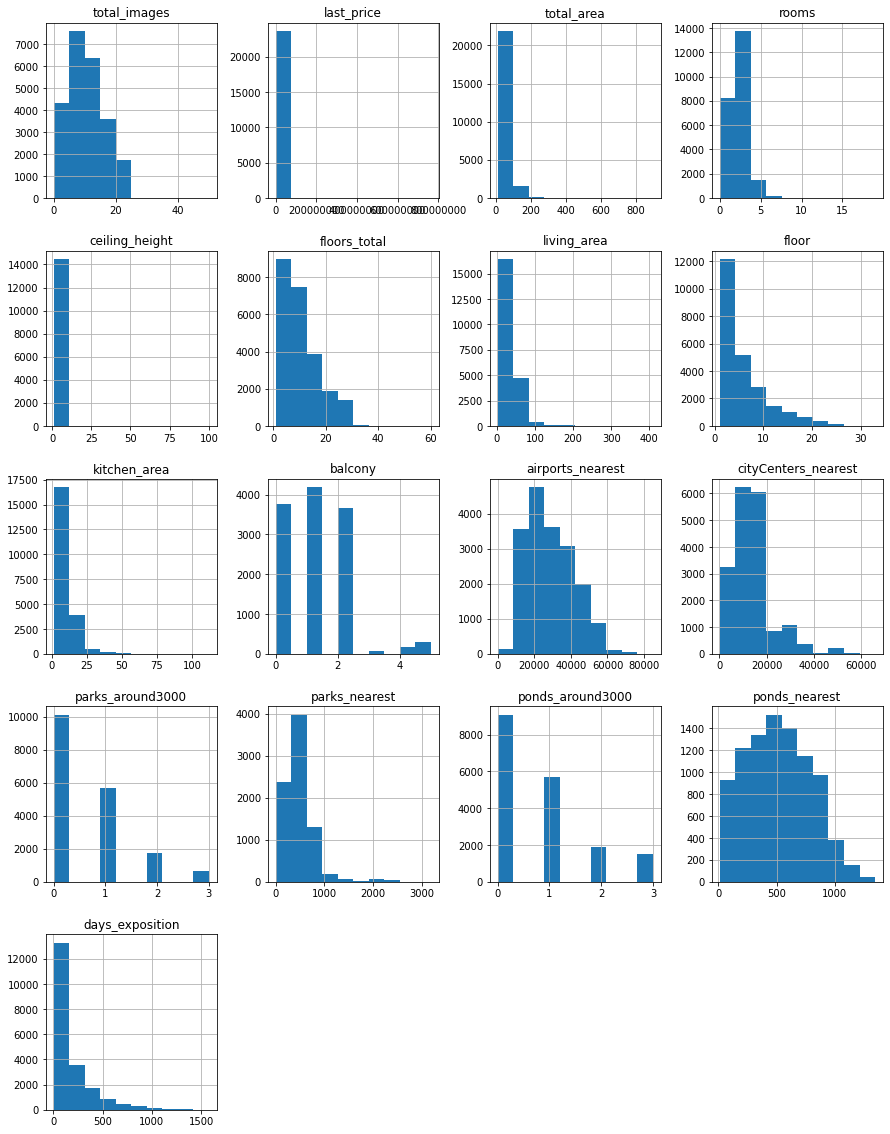

In [ ]:
data_raw.hist(figsize=(15, 20));

Трудно сделать какие-то конкретные выводы, но видно, что большинство объявлений снимаются в течение 100-150 дней и большая часть недвижимости расположена ~в 6-20 км. от центра города.

### Предобработка данных

Проведем стандартную предобработку, включающаю проверку явных дубликатов, нулевых и пропущенных значений, а также изменим тип данных и преобразуем категориальные переменные.

In [ ]:
data = data_raw.copy()

#### Изучение пропусков в данных

In [ ]:
pd.concat([data.isna().sum(), data.isna().mean()],
          axis=1, keys=['sum', 'conversation']).style.format({'conversation': '{:.2%}'}).background_gradient('coolwarm')

,sum,conversation
total_images,0,0.00%
last_price,0,0.00%
total_area,0,0.00%
first_day_exposition,0,0.00%
rooms,0,0.00%
ceiling_height,9195,38.80%
floors_total,86,0.36%
living_area,1903,8.03%
floor,0,0.00%
is_apartment,20924,88.29%


В данных присутсвует достаточно много пропусков, это нужно исправить. Создадим таблицу с указанием доли пропусков по каждой колонке и отсортируем значения по убыванию, чтобы сэкономить наше время и потом удалить пропуски, где доля составляет не более 1%.

Постраемся заполнить пропуски, где это возможно.

#### Проверка дубликатов

In [ ]:
data.duplicated().sum()

0

In [ ]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [ ]:
len(data['locality_name'].unique())

365

`locality_name` - это название населённого пункта. Мы можем наблюдать неявные дубликаты в словосочетаниях `поселок` и `посёлок`, данная ошибка возникла в связи с тем, что люди могли указывать название населенного пункта в свободной форме. Правильным решением было бы при вводе населенного пункта предлагать пользователям выбрать из предложенных. В таком случае они бы имели категориальный тип данных и можно было бы избежать случаев, когда пришлось бы обрабатывать неявные дубликаты по типу насленного пункта как `деревня Кудрово` и `Кудрово`.

In [ ]:
def fix_locality_name(value):
    if str(value) == 'nan':
        return

    localities = ['Мурино', 'Кудрово']
    words = value.split(' ')

    if words[0] == 'посёлок':
        words[0] = 'поселок'

    for locality in localities:
        if locality in words:
            return locality

    return ' '.join(words)

In [ ]:
data['locality_name'] = data['locality_name'].apply(fix_locality_name)

In [ ]:
len(data['locality_name'].unique())

330

#### Заполнение пропусков

Удалим пропуски, которые составили менее `1%`.

In [ ]:
data = data.dropna(subset=['locality_name','floors_total'])

In [ ]:
data['is_apartment'].unique()

array([nan, False, True], dtype=object)

Неизвестно какую цель имеет параметр `is_apartment`, т.к. в легенде нет никакой конкретики, доля пропусков составляет `88.29%`. Столбец `is_apartment` скорее всего появился не с самого начала ведения записей, поэтому все пропущенные значения заменим на `False`. По этой же причине мы вынуждены будем игнрировать их в ходе нашего исследования.

In [ ]:
data['is_apartment'] = data['is_apartment'].fillna(False)

In [ ]:
data['days_exposition'].unique()

array([  nan,   81.,  558., ..., 1360., 1007.,  971.])

`days_exposition` – сколько дней было размещено объявление (от публикации до снятия). В данной колонке содержится `3181` запись, что составляет `13,42%` скорее всего это связано с какой-то технической ошибкой, т.к. по `first_day_exposition` нет пропусков. Удалять данные не стоит, т.к. другие параметры несут полезную информацию, поэтому можно заменить значения на заглушку `-1`.

In [ ]:
data['days_exposition'] = data['days_exposition'].fillna(-1)

`parks_nearest`, `ponds_nearest`, `airports_nearest`, `cityCenters_nearest`, `ponds_around3000`, `parks_around3000` - эти данные мы не можем заполнить медианными значениями, либо чем-то еще, а вручную на это уйдет уйма времени. Скорее всего людии сами не указали данную информацию, либо это техническая ошибка, допущенная при сборе данных.

С `living_area` и `kitchen_area` тоже самое, но теоретически мы могли бы попробовать заполнить их медианными данными с учетом количества комнат, но нужно учесть тот факт, что иногда бывают двукомнатные квартиры с площадью `50 кв. метров`, а иногда эта цифра доходит до `70-85 кв. метров`, тоже самое касается трехкомнатных и более квартир. Главное, что нет пропусков в `total_area`, а остальные параметры площади уже индивидуальны при поиске и выборе жилья. Также мы бы теоретически могли бы найти площадь путем разности, но часто есть данные только по столбцу `total_area`.

In [ ]:
data['balcony'].sort_values().unique()

array([ 0.,  1.,  2.,  3.,  4.,  5., nan])

`balcony` – число балконов. Вероятнее всего пропуск может лишь говорить о том, что балконы отсутсвуют, поэтому заполним пропуски значением `0`.

In [ ]:
data['balcony'] = data['balcony'].fillna(0)

`floors_total` – всего этажей в доме. Вероятнее всего это одноэтажные дома, поэтому заполним пропуски значением `1`. Если наше предположение ошибочно, то 86 записей не должны сильно сдвинуть распределение.

In [ ]:
data['floors_total'].sort_values().unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 33., 34., 35., 36., 37., 52., 60.])

In [ ]:
data['floors_total'] = data['floors_total'].fillna(1)

`ceiling_height` – высота потолков. Вероятнее всего владельцы не знают точной высоты своих потолков, поэтому они не указали ее. В среднем, этот параметр должен колебаться в пределах 2.4 - 3.2 м. Минимальная высота потолка определяется строительными нормами и правилами как 2.4 м, поэтому мы укажем значение `2.4`.

In [ ]:
data['ceiling_height'] = data['ceiling_height'].fillna(2.4)

#### Работа с аномальными данными

In [ ]:
data['ceiling_height'].sort_values().unique()

array([  1.  ,   1.2 ,   1.75,   2.  ,   2.2 ,   2.25,   2.3 ,   2.34,
         2.4 ,   2.45,   2.46,   2.47,   2.48,   2.49,   2.5 ,   2.51,
         2.52,   2.53,   2.54,   2.55,   2.56,   2.57,   2.58,   2.59,
         2.6 ,   2.61,   2.62,   2.63,   2.64,   2.65,   2.66,   2.67,
         2.68,   2.69,   2.7 ,   2.71,   2.72,   2.73,   2.74,   2.75,
         2.76,   2.77,   2.78,   2.79,   2.8 ,   2.81,   2.82,   2.83,
         2.84,   2.85,   2.86,   2.87,   2.88,   2.89,   2.9 ,   2.91,
         2.92,   2.93,   2.94,   2.95,   2.96,   2.97,   2.98,   2.99,
         3.  ,   3.01,   3.02,   3.03,   3.04,   3.05,   3.06,   3.07,
         3.08,   3.09,   3.1 ,   3.11,   3.12,   3.13,   3.14,   3.15,
         3.16,   3.17,   3.18,   3.2 ,   3.21,   3.22,   3.23,   3.24,
         3.25,   3.26,   3.27,   3.28,   3.29,   3.3 ,   3.31,   3.32,
         3.33,   3.34,   3.35,   3.36,   3.37,   3.38,   3.39,   3.4 ,
         3.42,   3.43,   3.44,   3.45,   3.46,   3.47,   3.48,   3.49,
      

В данной колонке наблюдаются аномалии, вероятнее всего при создании объявлений вводе данных произошли ошибки (опечатки), которые можно списать на человеческий фактор.

In [ ]:
len(data.query('ceiling_height < 2 or ceiling_height > 10.3'))

27

Всего таких аномалий `27` - это явно человеческий фактор.

In [ ]:
data.query('ceiling_height < 2 or ceiling_height > 10.3')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
355,17,"3,600,000.00",55.20,2018-07-12T00:00:00,2,25.00,5.00,32.00,2,False,False,False,NaN,2.00,Гатчина,NaN,NaN,NaN,NaN,NaN,NaN,259.00
3148,14,"2,900,000.00",75.00,2018-11-12T00:00:00,3,32.00,3.00,53.00,2,False,False,False,8.00,0.00,Волхов,NaN,NaN,NaN,NaN,NaN,NaN,-1.00
4643,0,"4,300,000.00",45.00,2018-02-01T00:00:00,2,25.00,9.00,30.00,2,False,False,False,7.00,1.00,Санкт-Петербург,"12,016.00","13,256.00",1.00,658.00,1.00,331.00,181.00
4876,7,"3,000,000.00",25.00,2017-09-27T00:00:00,0,27.00,25.00,17.00,17,False,False,True,NaN,2.00,Мурино,NaN,NaN,NaN,NaN,NaN,NaN,28.00
5076,0,"3,850,000.00",30.50,2018-10-03T00:00:00,1,24.00,5.00,19.50,1,True,False,False,5.50,0.00,Санкт-Петербург,"29,686.00","8,389.00",3.00,397.00,1.00,578.00,7.00
5246,0,"2,500,000.00",54.00,2017-10-13T00:00:00,2,27.00,5.00,30.00,3,False,False,False,9.00,2.00,деревня Мины,NaN,NaN,NaN,NaN,NaN,NaN,540.00
5669,4,"4,400,000.00",50.00,2017-08-08T00:00:00,2,26.00,9.00,21.30,3,False,False,False,7.00,2.00,Санкт-Петербург,"28,981.00","10,912.00",1.00,305.00,0.00,NaN,267.00
5712,5,"1,500,000.00",42.80,2017-08-14T00:00:00,2,1.20,2.00,27.50,1,False,False,False,5.20,0.00,городской посёлок Мга,NaN,NaN,NaN,NaN,NaN,NaN,248.00
5807,17,"8,150,000.00",80.00,2019-01-09T00:00:00,2,27.00,36.00,41.00,13,False,False,False,12.00,5.00,Санкт-Петербург,"18,732.00","20,444.00",0.00,NaN,3.00,80.00,38.00
6246,6,"3,300,000.00",44.40,2019-03-25T00:00:00,2,25.00,5.00,31.30,5,False,False,False,5.70,0.00,Кронштадт,"68,923.00","50,649.00",1.00,417.00,2.00,73.00,-1.00


Потолки, которые выше `10.3` метров мы скорректируем, поделив их на `10`, а недвижимость с потолками ниже `2` метров мы удалим. Вполне возможно, что люди не знают точной высоты потолка, но знают, что она точно составляет 2 метра.

In [ ]:
data.loc[data['ceiling_height'] > 10.3, 'ceiling_height'] /= 10
data = data.query('ceiling_height > 2')

In [ ]:
len(data.query('ceiling_height < 2 or ceiling_height > 10.3'))

0

#### Изменение типа данных

Поменяем тип данных `float` на `int`.

In [ ]:
for column_name in ['last_price', 'balcony', 'floors_total', 'days_exposition']:
    data[column_name] = data[column_name].astype('int')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23549 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23549 non-null  int64  
 1   last_price            23549 non-null  int64  
 2   total_area            23549 non-null  float64
 3   first_day_exposition  23549 non-null  object 
 4   rooms                 23549 non-null  int64  
 5   ceiling_height        23549 non-null  float64
 6   floors_total          23549 non-null  int64  
 7   living_area           21686 non-null  float64
 8   floor                 23549 non-null  int64  
 9   is_apartment          23549 non-null  bool   
 10  studio                23549 non-null  bool   
 11  open_plan             23549 non-null  bool   
 12  kitchen_area          21329 non-null  float64
 13  balcony               23549 non-null  int64  
 14  locality_name         23549 non-null  object 
 15  airports_nearest   

`first_day_exposition` приведем к к формату `%Y-%m-%d`.

In [ ]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d')

#### Вывод

1. Явные дубликаты в данных отсутсвуют.
2. Некоторые колонки имеют неверный тип данных.
3. Присутсвуют ошибки написания солова `поселок`, различае заключается в буквах `е` и `ё` в колонке `locality_name`.
4. В данных имеется очень много пропусков.

### Посчитайте и добавьте в таблицу новые столбцы

#### Цена за квадратный метр

In [ ]:
data['price_square_meter'] = data['last_price'] / data['total_area']

#### День недели, месяц и год публикации объявления

In [ ]:
data['day_exposition'] = data['first_day_exposition'].dt.weekday
data['month_exposition'] = data['first_day_exposition'].dt.month
data['year_exposition'] = data['first_day_exposition'].dt.year

#### Тип этажа квартиры

In [ ]:
def floor_type(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    return 'другой'
data['floor_category'] = data.apply(floor_type, axis=1)

#### Расстояние до центра города в километрах

In [ ]:
data['cityCenters_nearest_km'] = (data['cityCenters_nearest'] / 1000).round(0)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23549 entries, 0 to 23698
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_images            23549 non-null  int64         
 1   last_price              23549 non-null  int64         
 2   total_area              23549 non-null  float64       
 3   first_day_exposition    23549 non-null  datetime64[ns]
 4   rooms                   23549 non-null  int64         
 5   ceiling_height          23549 non-null  float64       
 6   floors_total            23549 non-null  int64         
 7   living_area             21686 non-null  float64       
 8   floor                   23549 non-null  int64         
 9   is_apartment            23549 non-null  bool          
 10  studio                  23549 non-null  bool          
 11  open_plan               23549 non-null  bool          
 12  kitchen_area            21329 non-null  float6

### Исследовательский анализ данных

#### Анализ основных параметров

##### Общая площадь

In [ ]:
data['total_area'].describe()

count   23,549.00
mean        60.33
std         35.67
min         12.00
25%         40.00
50%         52.00
75%         69.70
max        900.00
Name: total_area, dtype: float64

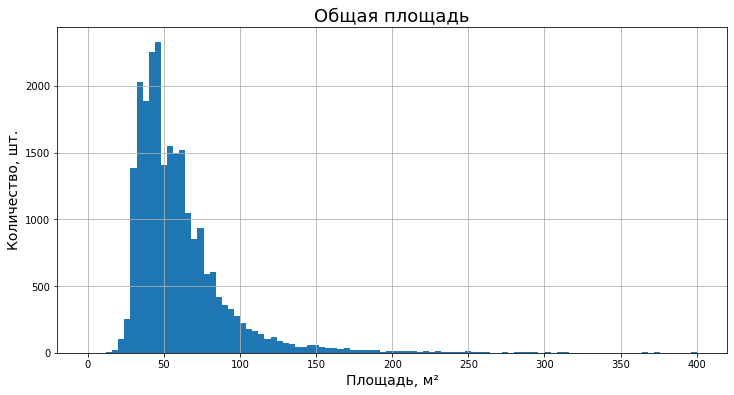

In [ ]:
data.hist('total_area', bins=100, range=(0, 400))
plt.title('Общая площадь', size=18)
plt.xlabel('Площадь, м²', size=14)
plt.ylabel('Количество, шт.', size=14)
plt.show()

По гистограмме и описанию можно сделать вывод, что большинство значений площади объектов находятся в пределах от 40 до 70 кв. м. Однако, после 200 кв. м. объектов все меньше и они почти сливаются с осью, можно предположить, что это какие-то нежилые объекты по типу складских помещений или торговых павильонов, либо произошла техничкая ошибка при собре данных или случился человческий фактор при вводе значений. Медианное знаачение составляет 52 кв. м.

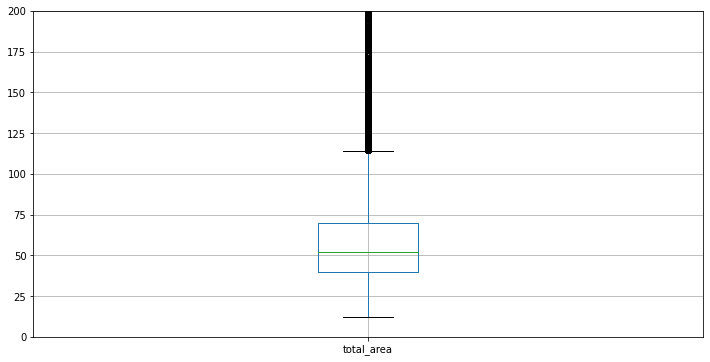

In [ ]:
plt.ylim(0, 200)
data.boxplot('total_area')
plt.show()

Если посмотреть на "усы", то можно увидеть наш рабочий диапазон в пределах от 12 до 115 кв. м., все что вне данного диапазона - выбросы, которые следует удалить из данных.

In [ ]:
data = data.query('12 <= total_area <= 115')

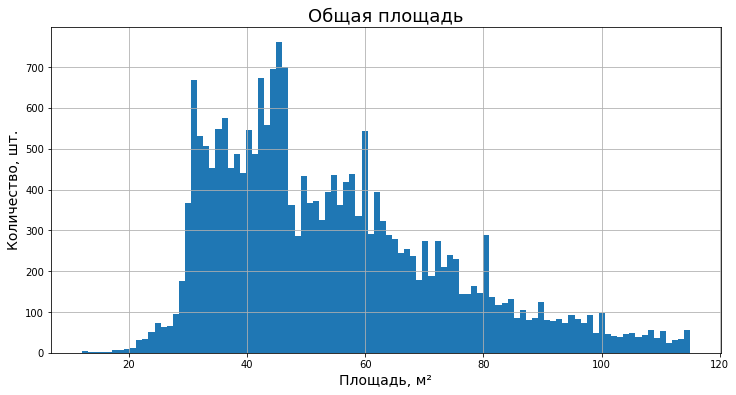

In [ ]:
data.hist('total_area', bins=100)
plt.title('Общая площадь', size=18)
plt.xlabel('Площадь, м²', size=14)
plt.ylabel('Количество, шт.', size=14)
plt.show()

##### Жилая площадь

In [ ]:
data['living_area'].describe()

count   20,602.00
mean        31.11
std         13.55
min          2.00
25%         18.30
50%         29.80
75%         40.00
max        101.00
Name: living_area, dtype: float64

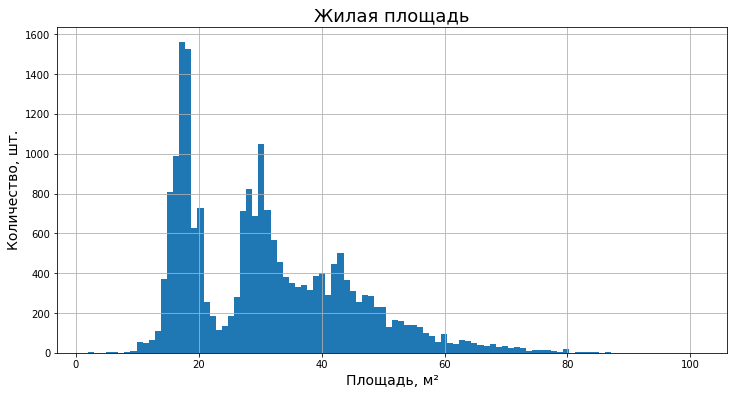

In [ ]:
data.hist('living_area', bins=100)
plt.title('Жилая площадь', size=18)
plt.xlabel('Площадь, м²', size=14)
plt.ylabel('Количество, шт.', size=14)
plt.show()

По гистограмме и описанию можно сделать вывод, что большинство значений жилой площади объектов находятся в пределах от 18 до 40 кв. м. Медианное знаачение составляет 29 кв. м.

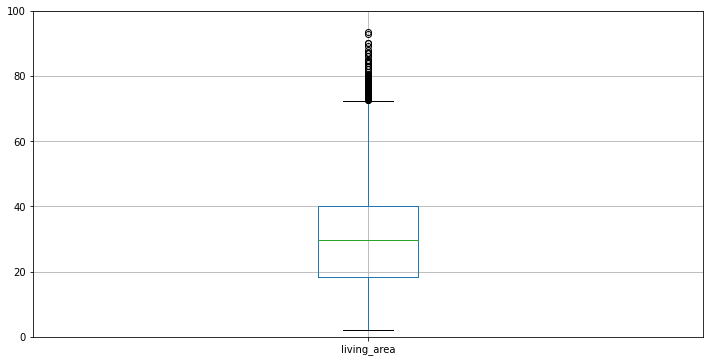

In [ ]:
plt.ylim(0, 100)
data.boxplot('living_area')
plt.show()

Если посмотреть на "усы", то можно увидеть наш рабочий диапазон в пределах от 2 до 75 кв. м., все что вне данного диапазона - выбросы, которые следует удалить из данных.

In [ ]:
data = data.query('2 <= living_area <= 75')

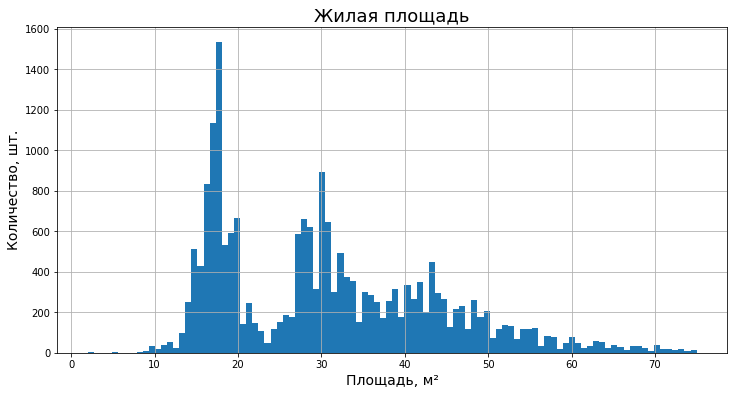

In [ ]:
data.hist('living_area', bins=100)
plt.title('Жилая площадь', size=18)
plt.xlabel('Площадь, м²', size=14)
plt.ylabel('Количество, шт.', size=14)
plt.show()

##### Площадь кухни

In [ ]:
data['kitchen_area'].describe()

count   19,752.00
mean         9.86
std          4.30
min          1.30
25%          7.00
50%          9.00
75%         11.20
max         60.00
Name: kitchen_area, dtype: float64

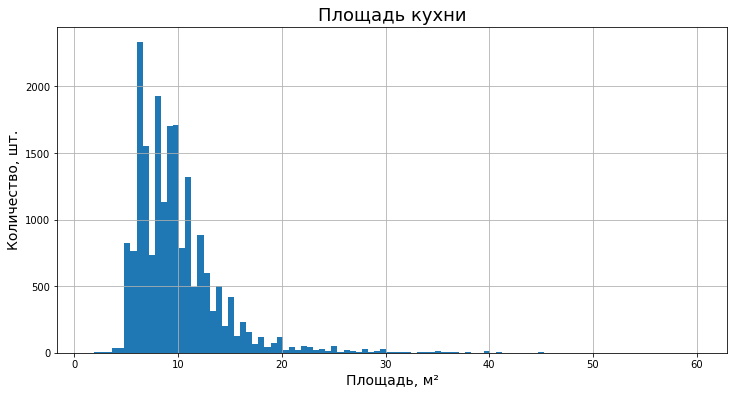

In [ ]:
data.hist('kitchen_area', bins=100)
plt.title('Площадь кухни', size=18)
plt.xlabel('Площадь, м²', size=14)
plt.ylabel('Количество, шт.', size=14)
plt.show()

По гистограмме и описанию можно сделать вывод, что большинство значений площади кухни объектов находятся в пределах от 7 до 12 кв. м. Медианное знаачение составляет 9 кв. м.

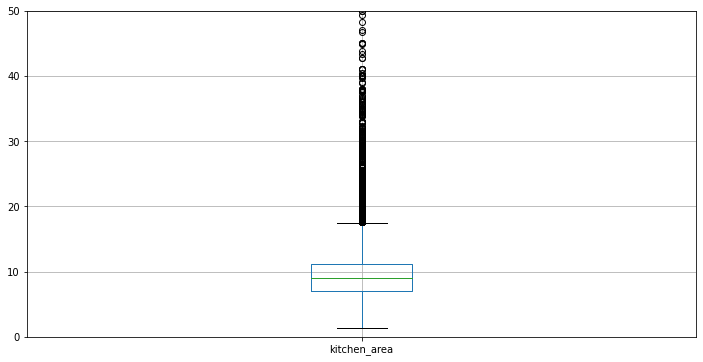

In [ ]:
plt.ylim(0, 50)
data.boxplot('kitchen_area')
plt.show()

Если посмотреть на "усы", то можно увидеть наш рабочий диапазон в пределах от 2 до 18 кв. м., все что вне данного диапазона - выбросы, которые следует удалить из данных.

In [ ]:
data = data.query('2 <= kitchen_area <= 18')

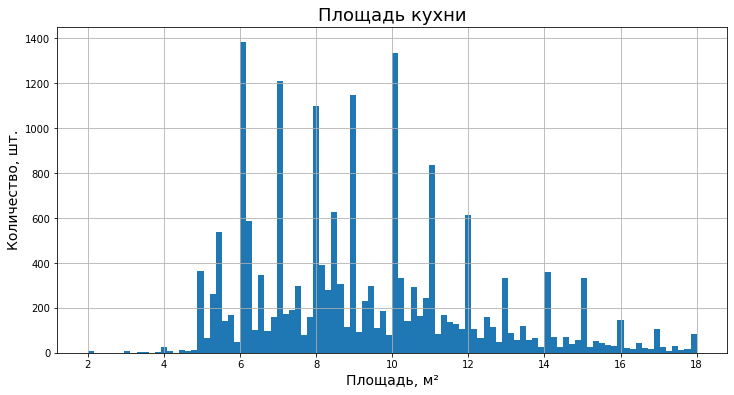

In [ ]:
data.hist('kitchen_area', bins=100)
plt.title('Площадь кухни', size=18)
plt.xlabel('Площадь, м²', size=14)
plt.ylabel('Количество, шт.', size=14)
plt.show()

##### Цена объекта

In [ ]:
data['last_price'].describe()

count       18,971.00
mean     5,102,305.46
std      2,916,628.76
min        430,000.00
25%      3,400,000.00
50%      4,500,000.00
75%      6,050,000.00
max     53,000,000.00
Name: last_price, dtype: float64

In [ ]:
data.sort_values('last_price')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_square_meter,day_exposition,month_exposition,year_exposition,floor_category,cityCenters_nearest_km
17456,7,430000,30.40,2019-04-22,1,2.40,2,16.00,1,False,False,False,6.00,0,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,-1,"14,144.74",0,4,2019,первый,NaN
9581,7,450000,43.40,2018-08-31,2,2.40,5,30.30,3,False,False,False,5.50,0,деревня Старополье,NaN,NaN,NaN,NaN,NaN,NaN,96,"10,368.66",4,8,2018,другой,NaN
17676,0,450000,36.50,2018-02-01,1,2.40,5,17.30,4,False,False,False,8.50,1,деревня Ям-Тесово,NaN,NaN,NaN,NaN,NaN,NaN,120,"12,328.77",3,2,2018,другой,NaN
5698,7,450000,42.00,2017-07-31,2,2.40,1,23.00,1,False,False,False,5.80,0,городской посёлок Будогощь,NaN,NaN,NaN,NaN,NaN,NaN,233,"10,714.29",0,7,2017,первый,NaN
18867,1,470000,41.00,2018-02-11,1,2.40,5,32.00,3,False,False,False,9.00,0,деревня Выскатка,NaN,NaN,NaN,NaN,NaN,NaN,46,"11,463.41",6,2,2018,другой,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12916,6,39990000,67.70,2015-06-25,3,3.10,7,42.90,6,False,False,False,9.00,0,Санкт-Петербург,"25,685.00","2,136.00",1.00,72.00,3.00,202.00,-1,"590,694.24",3,6,2015,другой,2.00
6127,13,40000000,65.30,2017-07-13,2,4.10,5,45.00,2,False,False,False,12.00,2,Санкт-Петербург,"23,308.00","2,380.00",1.00,473.00,1.00,283.00,497,"612,557.43",3,7,2017,другой,2.00
7596,18,40000000,110.00,2018-02-19,3,3.20,4,74.40,2,False,False,False,12.00,0,Санкт-Петербург,"23,197.00","2,383.00",2.00,339.00,1.00,93.00,-1,"363,636.36",0,2,2018,другой,2.00
7136,0,48000000,108.00,2018-02-01,3,2.40,5,61.00,2,False,False,False,13.50,0,Санкт-Петербург,"24,632.00","3,180.00",1.00,551.00,3.00,415.00,144,"444,444.44",3,2,2018,другой,3.00


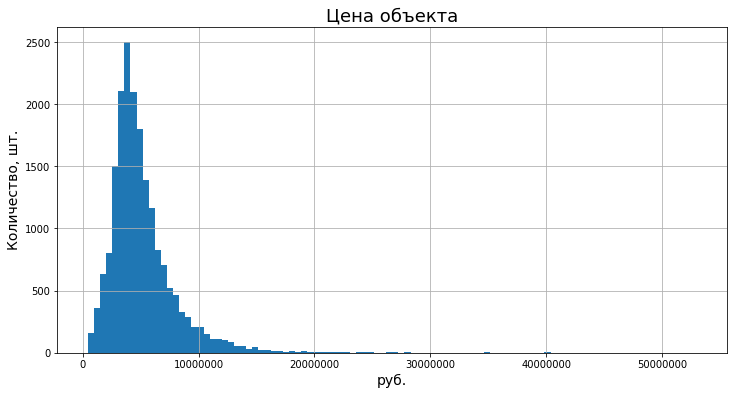

In [ ]:
data.hist('last_price', bins=100)
plt.title('Цена объекта', size=18)
plt.xlabel('руб.', size=14)
plt.ylabel('Количество, шт.', size=14)
plt.show()

По гистограмме и описанию трудно сделать вывод, но исходся из данных можно понять, что ценовой диапазон объектов находятся в пределах от 430 тыс. руб. до 53 млн. руб.

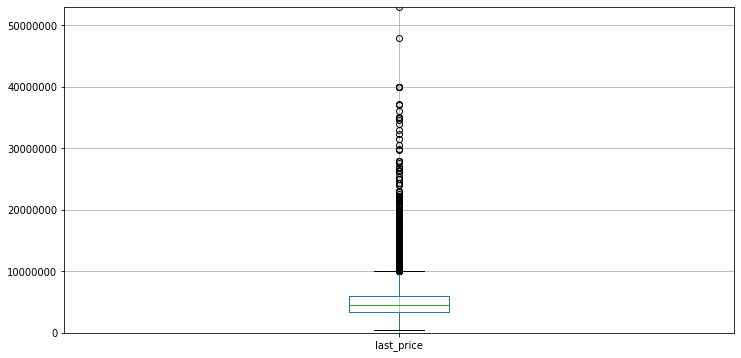

In [ ]:
plt.ylim(0, 53000000)
data.boxplot('last_price')
plt.show()

Трудно увидеть необходимые границы, поэтому уменьшим диапазоны оси `y` и более детально рассмотрим каждый "ус".

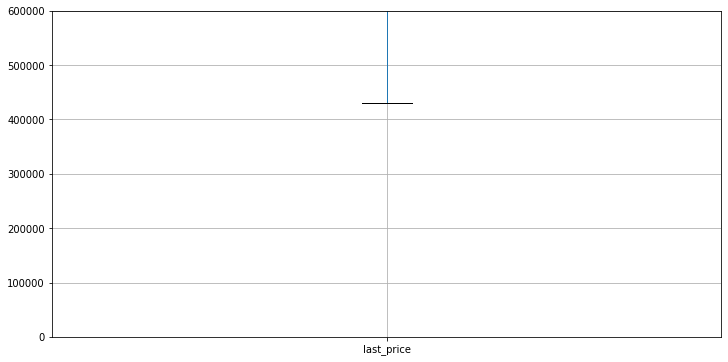

In [ ]:
plt.ylim(0, 600000)
data.boxplot('last_price')
plt.show()

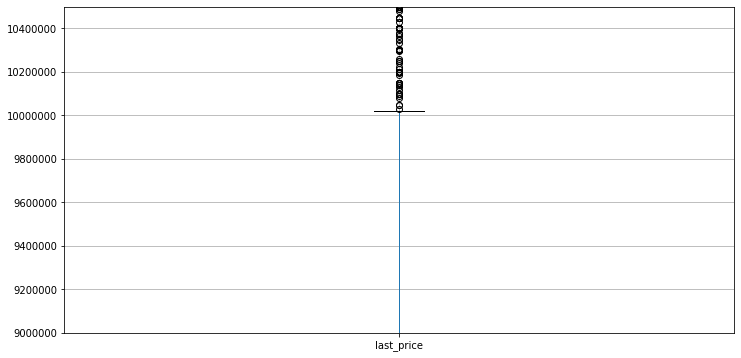

In [ ]:
plt.ylim(9000000, 10500000)
data.boxplot('last_price')
plt.show()

Если посмотреть на "усы", то можно увидеть наш рабочий диапазон в пределах от 430 тыс. руб. до ~10.1 млн. руб., все что вне данного диапазона - выбросы, которые следует удалить из данных.

In [ ]:
data = data.query('430000 <= last_price <= 10100000')

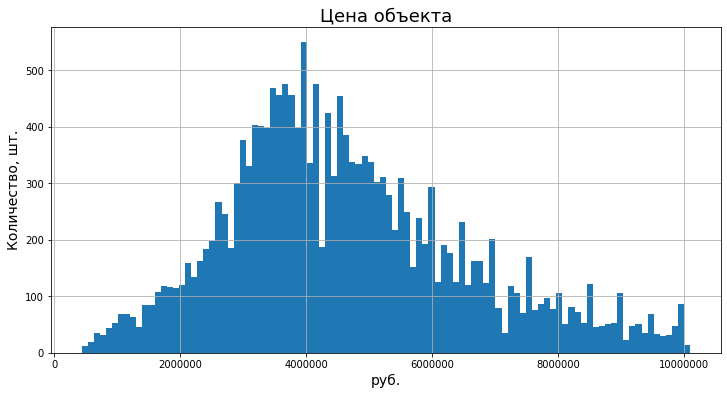

In [ ]:
data.hist('last_price', bins=100)
plt.title('Цена объекта', size=18)
plt.xlabel('руб.', size=14)
plt.ylabel('Количество, шт.', size=14)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}'))
plt.show()

По гистограмме можно сделать вывод, что в основном ценовой диапазон объектов находятся в пределах от 3 млн. руб. до 5,3 млн. руб.

##### Количество комнат

In [ ]:
data['rooms'].describe()

count   17,987.00
mean         1.91
std          0.86
min          1.00
25%          1.00
50%          2.00
75%          3.00
max          6.00
Name: rooms, dtype: float64

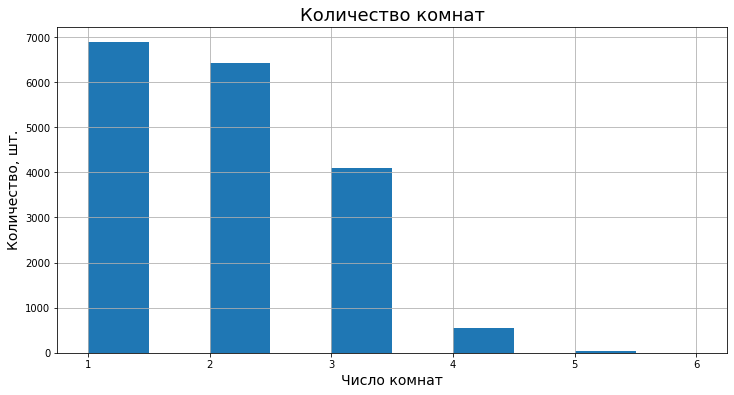

In [ ]:
data.hist('rooms', bins=10)
plt.title('Количество комнат', size=18)
plt.xlabel('Число комнат', size=14)
plt.ylabel('Количество, шт.', size=14)
plt.show()

По гистограмме и описанию можно сделать вывод, что больше всего предложений по однокомнатным и двукомнатным квартирам, и чуть реже трехкомнатным квартирам.

##### Высота потолков

In [ ]:
data['ceiling_height'].describe()

count   17,987.00
mean         2.57
std          0.22
min          2.20
25%          2.40
50%          2.50
75%          2.65
max          8.30
Name: ceiling_height, dtype: float64

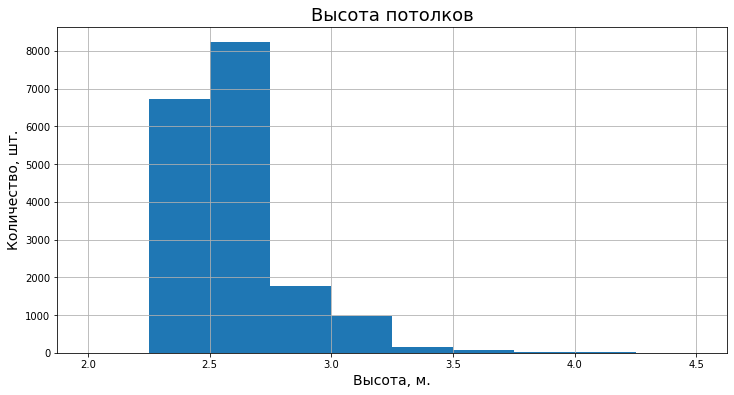

In [ ]:
data.hist('ceiling_height', bins=10, range=(2, 4.5))
plt.title('Высота потолков', size=18)
plt.xlabel('Высота, м.', size=14)
plt.ylabel('Количество, шт.', size=14)
plt.show()

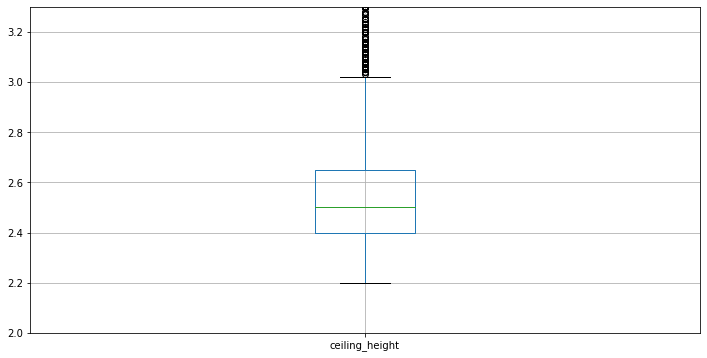

In [ ]:
plt.ylim(2, 3.3)
data.boxplot('ceiling_height')
plt.show()

По гистограмме, описанию и "ящику с усами" можно сделать вывод, что в основном объекты имеют высоту потолков от 2.4 до 2.65 метров, нижней границей является 2.2 метра, а верхней чуть более 3 метров.

##### Этажи квартиры

In [ ]:
data['floor'].describe()

count   17,987.00
mean         5.79
std          4.78
min          1.00
25%          2.00
50%          4.00
75%          8.00
max         33.00
Name: floor, dtype: float64

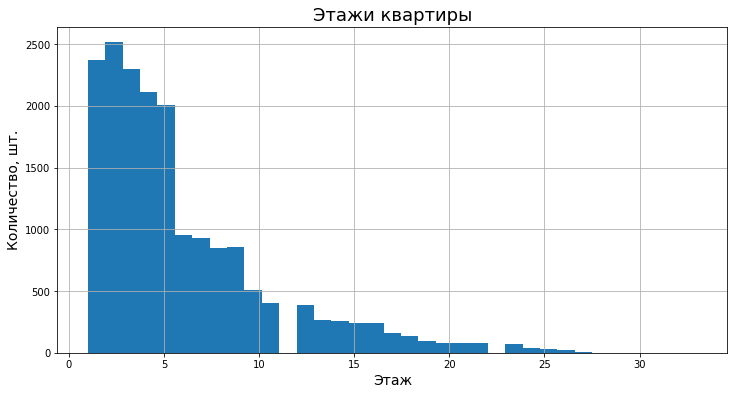

In [ ]:
data.hist('floor', bins=35)
plt.title('Этажи квартиры', size=18)
plt.xlabel('Этаж', size=14)
plt.ylabel('Количество, шт.', size=14)
plt.show()

По гистограмме и описанию можно сделать вывод, что большая часть квартир располагается на 2-8-х этажах.

##### Тип этажа квартиры

In [ ]:
data.groupby('floor_category')['floor_category'].count()

floor_category
другой       13105
первый        2371
последний     2511
Name: floor_category, dtype: int64

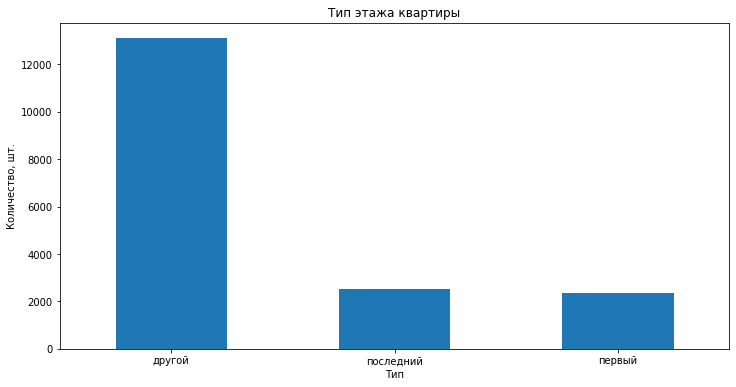

In [ ]:
data.groupby('floor_category')['floor_category'].count().sort_values(ascending=False). \
plot(title='Тип этажа квартиры', xlabel='Тип', ylabel='Количество, шт.', kind='bar')
plt.xticks(rotation=360);

По гистограмме и описанию можно сделать вывод, что больше всего предложений не приходится на первый или последний этаж, что вполне логично.

##### Общее количество этажей в доме

In [ ]:
data['floors_total'].describe()

count   17,987.00
mean        10.57
std          6.48
min          1.00
25%          5.00
50%          9.00
75%         15.00
max         60.00
Name: floors_total, dtype: float64

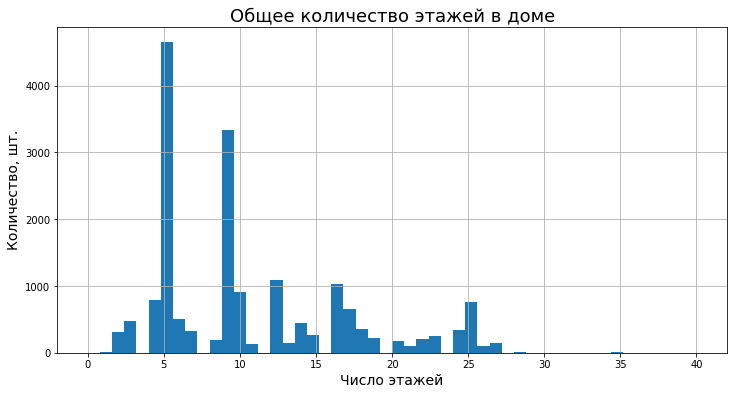

In [ ]:
data.hist('floors_total', bins=50, range=(0, 40))
plt.title('Общее количество этажей в доме', size=18)
plt.xlabel('Число этажей', size=14)
plt.ylabel('Количество, шт.', size=14)
plt.show()

По гистограмме и описанию можно сделать вывод, что в основном объекты имееют от 5 до 15 этажей, медианное значение составляет 9 этажей.

##### Расстояние до центра города в метрах

In [ ]:
data['cityCenters_nearest'].describe()

count   13,508.00
mean    15,314.96
std      8,579.99
min        208.00
25%     10,945.50
50%     13,819.50
75%     16,788.00
max     65,968.00
Name: cityCenters_nearest, dtype: float64

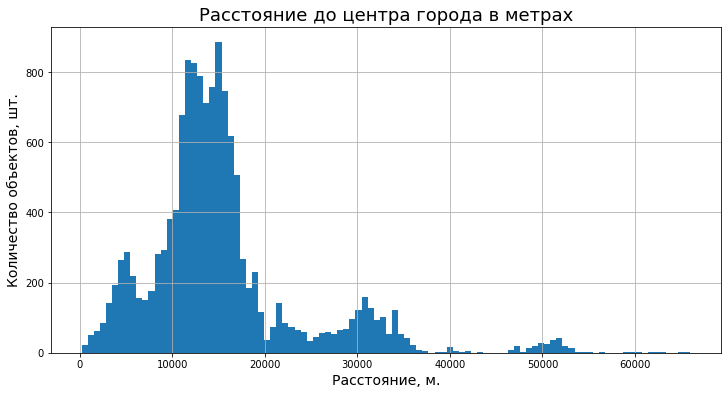

In [ ]:
data.hist('cityCenters_nearest', bins=100)
plt.title('Расстояние до центра города в метрах', size=18)
plt.xlabel('Расстояние, м.', size=14)
plt.ylabel('Количество объектов, шт.', size=14)
plt.show()

По гистограмме и описанию можно сделать вывод, что в основном объекты находятся от центра в радиусе от 11 до 17 км., что довольно близко, если рассматривать передвижение на общественном или личном транспорте. Медианное значение составило 14 км.

##### Расстояние до ближайшего аэропорта

In [ ]:
data['airports_nearest'].describe()

count   13,497.00
mean    28,992.38
std     13,118.81
min          0.00
25%     17,837.00
50%     27,310.00
75%     37,894.00
max     84,869.00
Name: airports_nearest, dtype: float64

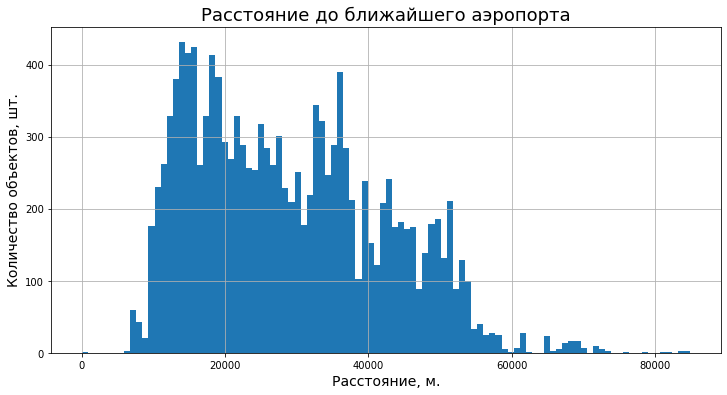

In [ ]:
data.hist('airports_nearest', bins=100)
plt.title('Расстояние до ближайшего аэропорта', size=18)
plt.xlabel('Расстояние, м.', size=14)
plt.ylabel('Количество объектов, шт.', size=14)
plt.show()

По гистограмме и описанию можно сделать вывод, что аэропорты расположены в раудисе от 18 до 38 км., что довольно близко по отношению к аэропортам. Медианное значение составило 27 км.

##### Расстояние до ближайшего парка

In [ ]:
data['parks_nearest'].describe()

count   5,537.00
mean      483.92
std       317.40
min         1.00
25%       290.00
50%       456.00
75%       612.00
max     3,190.00
Name: parks_nearest, dtype: float64

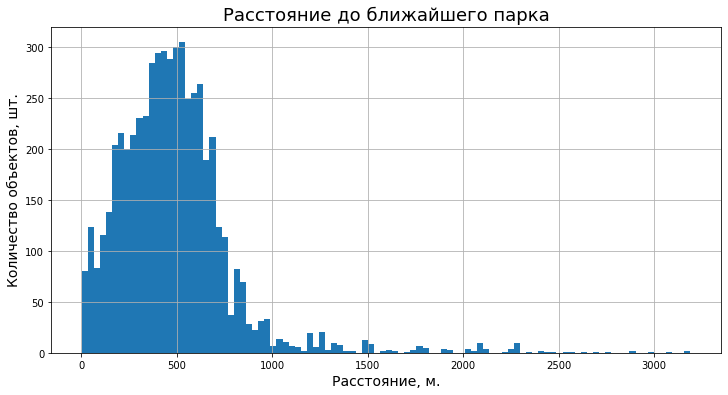

In [ ]:
data.hist('parks_nearest', bins=100)
plt.title('Расстояние до ближайшего парка', size=18)
plt.xlabel('Расстояние, м.', size=14)
plt.ylabel('Количество объектов, шт.', size=14)
plt.show()

In [ ]:
data.query('parks_nearest < 50')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_square_meter,day_exposition,month_exposition,year_exposition,floor_category,cityCenters_nearest_km
126,10,4050000,51.00,2019-04-23,2,2.40,5,30.50,1,False,False,False,6.60,0,Пушкин,"17,974.00","32,546.00",1.00,15.00,1.00,659.00,-1,"79,411.76",1,4,2019,первый,33.00
189,0,6150000,62.00,2017-10-13,3,2.40,9,41.50,5,False,False,False,8.50,2,Санкт-Петербург,"41,954.00","12,168.00",1.00,10.00,0.00,NaN,45,"99,193.55",4,10,2017,другой,12.00
214,5,4150000,50.41,2017-07-20,2,2.50,9,31.10,8,False,False,False,7.00,1,Санкт-Петербург,"41,954.00","12,168.00",1.00,10.00,0.00,NaN,274,"82,324.94",3,7,2017,другой,12.00
380,6,4600000,40.00,2018-12-12,1,2.65,17,18.00,2,False,False,False,11.40,2,Санкт-Петербург,"14,932.00","11,348.00",1.00,36.00,1.00,274.00,56,"115,000.00",2,12,2018,другой,11.00
455,20,8500000,65.00,2019-04-24,3,2.55,7,43.00,2,False,False,False,7.50,0,Санкт-Петербург,"28,927.00","7,866.00",2.00,15.00,3.00,293.00,-1,"130,769.23",2,4,2019,другой,8.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23053,2,3390000,38.00,2017-02-24,1,2.40,22,17.65,19,False,False,False,10.18,0,Санкт-Петербург,"8,426.00","12,082.00",2.00,24.00,1.00,271.00,533,"89,210.53",4,2,2017,другой,12.00
23123,0,1800000,32.00,2018-07-17,1,2.40,2,17.00,1,False,False,False,6.00,0,Ломоносов,"56,896.00","60,223.00",1.00,17.00,0.00,NaN,147,"56,250.00",1,7,2018,первый,60.00
23145,17,6300000,92.00,2017-07-20,3,2.40,16,46.00,7,False,False,False,14.00,0,Санкт-Петербург,"24,590.00","28,015.00",1.00,36.00,2.00,46.00,14,"68,478.26",3,7,2017,другой,28.00
23397,14,7500000,96.00,2019-04-10,3,2.40,6,57.20,5,False,False,False,10.80,0,Санкт-Петербург,"20,137.00","19,140.00",1.00,44.00,0.00,NaN,-1,"78,125.00",2,4,2019,другой,19.00


По описанию можно сделать вывод, что парки находятся в пешей доступности, они расположены в раудисе от 290 до 612 метров, выглядит правдоподно. Медианное значение составило 27 км. Однако, если взглянуть на гистрограмму, то видно, что присутствует значения, прилегающие к нулю - это пропущенные данные, причиной которых скорее всего служит то, что люди не знают о существовании парка, либо сколько до него метров. Также присутствуют "аномальные" значения, когда парк находится от 1 до 50 метров, во что верится с трудом, скорее всего кто-то считает аллею или площадку внутри своего ЖК парком, но это можно списать на человеческий фактор.

В качестве решения можно было бы указывать примерное расстояние до парка от района, в котором продается объект, с помощью Яндекс.Карт через координаты улицы, тогда бы нам не пришлось отбросить другие записи с отсутсвующими расстояними и исследование было бы более точным.

##### День и месяц публикации объявления

In [ ]:
data['day_exposition'].describe()

count   17,987.00
mean         2.55
std          1.79
min          0.00
25%          1.00
50%          3.00
75%          4.00
max          6.00
Name: day_exposition, dtype: float64

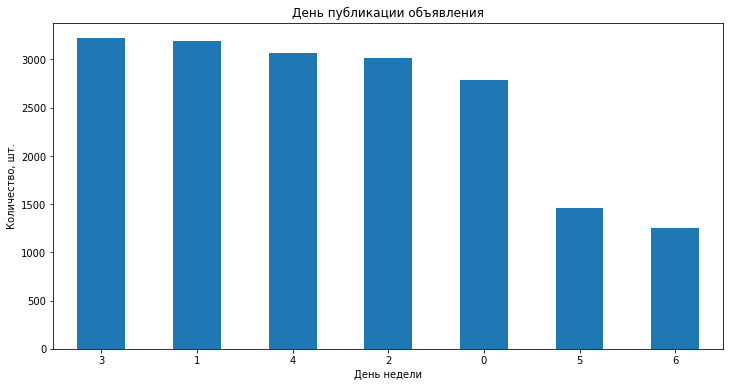

In [ ]:
data.groupby('day_exposition')['day_exposition'].count().sort_values(ascending=False). \
plot(title='День публикации объявления', xlabel='День недели', ylabel='Количество, шт.', kind='bar')
plt.xticks(rotation=360);

Если проанализировать гистограмму, то можно сделать вывод, что чаще всего объявления публикуются в рабочие дни, если конкретнее, то больше всего приходится на четверг и вторник, а также на пятницу и среду.Это все выглядит логично, т.к. риэлоры зачастую работают по графику 5/2, да и обычные люди по всей видимости предпочитают заниматься в выходным чем-то другим, а не публиковать объявления.

In [ ]:
data['month_exposition'].describe()

count   17,987.00
mean         6.42
std          3.46
min          1.00
25%          3.00
50%          6.00
75%         10.00
max         12.00
Name: month_exposition, dtype: float64

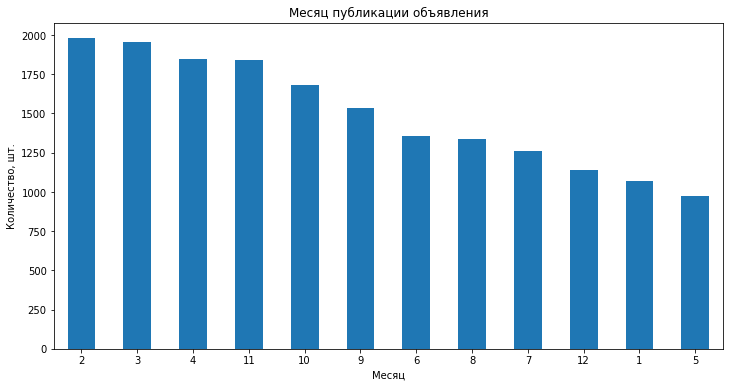

In [ ]:
data.groupby('month_exposition')['day_exposition'].count().sort_values(ascending=False). \
plot(title='Месяц публикации объявления', xlabel='Месяц', ylabel='Количество, шт.',kind='bar')
plt.xticks(rotation=360);

Если проанализировать гистограмму, то можно сделать вывод, что чаще всего объявления публикуются в феврале, если посмотреть на общую картину, то в основном пик приходится на начало весны и конец осени.

#### Анализ продаж объектов

In [ ]:
data['days_exposition'].describe()

count   15,773.00
mean       174.35
std        209.58
min          1.00
25%         42.00
50%         95.00
75%        223.00
max      1,580.00
Name: days_exposition, dtype: float64

Ранее мы использовали заглушку со значением `-1`, поэтому в дальнейших шагах мы ограничим диапазон при построении гистограмм.

In [ ]:
len(data.query('days_exposition == -1'))/len(data.query('days_exposition > 0')) * 100

14.036644899511824

`14%` от данных составляют объекты с пропущенными значениями. Предположительно эти значения появились в ходе технической ошибки при снятии объявления, либо при сборе данных.

Можно сделать вывод, что на продажу объекта уходит в основном 75 дней, быстрыми продажами считаются объекты, проданные в течение 23 дней, а долгими те, на которые уходит более 200 дней.

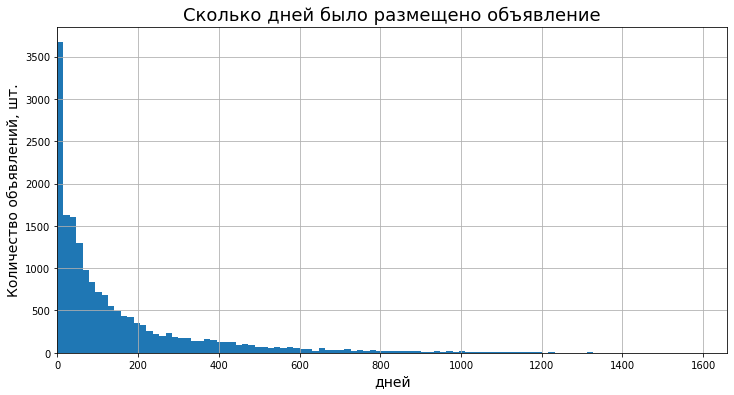

In [ ]:
data.hist('days_exposition', bins=100)
plt.xlim(xmin=0)
plt.title('Сколько дней было размещено объявление', size=18)
plt.xlabel('дней', size=14)
plt.ylabel('Количество объявлений, шт.', size=14)
plt.show()

На гистограмме видно, что пик продаж приходится на 40-50 дней, продажи на отметке 800 дней уже не так велики. По прошествии 1200 дней продаж почти нет. На участке более 1600 объявлений гистограмма сливается с нулём.

 Уменьшим диапазог до 200 дней, ведь именно в эти дни происходят основные продажи, возможно тут есть аномалии.

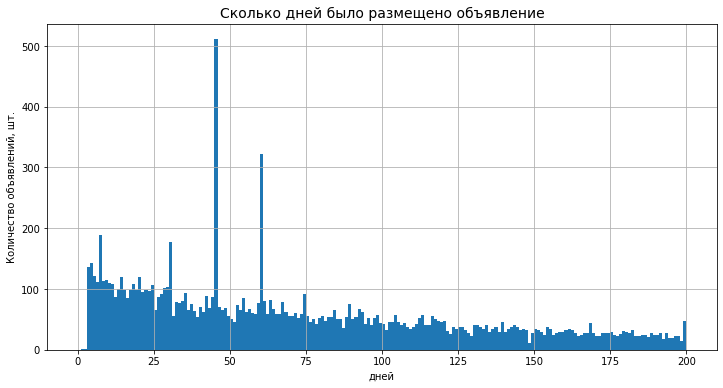

In [ ]:
data.hist('days_exposition', bins=200, range=(0, 200))
plt.title('Сколько дней было размещено объявление', size=18)
plt.xlabel('дней', size=14)
plt.ylabel('Количество объявлений, шт.', size=14)
plt.show()

На гистограмме видно, что пик продаж приходится на 40-45 и на 60 дней. Эти аномалии очень похожи на техническую особенность самой платформы: вероятнее, в эти дни платформа автоматически убирает объявления, если пользователь его не продлил. Чтобы изучить особенность поближе, построим "ящик с усами".

In [ ]:
data = data.query('days_exposition > 0')

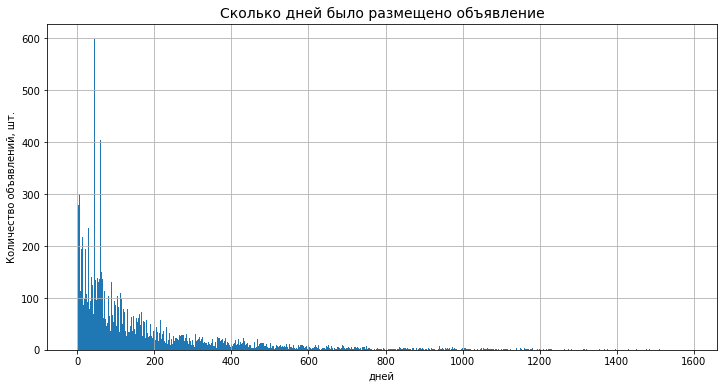

In [ ]:
data.hist('days_exposition', bins=1000)
plt.title('Сколько дней было размещено объявление', size=18)
plt.xlabel('дней', size=14)
plt.ylabel('Количество объявлений, шт.', size=14)
plt.show()

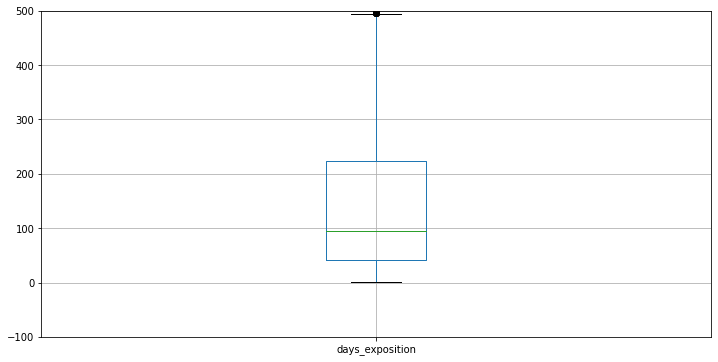

In [ ]:
plt.ylim(-100, 500)
data.boxplot('days_exposition')
plt.show()

In [ ]:
len(data.query('days_exposition < 7'))

515

Гисторграмма все еще сливается с `0`, но минимальное значение теперь составляет `1`, вполне возможно, что действительно объекты продаются в течение недели, либо кто-то передумал, или просто хотел узнать есть ли спрос или прицениться.

In [ ]:
np.percentile(data['days_exposition'], [25, 50, 75])

array([ 42.,  95., 223.])

`50%` объектов продаются в течение `95 дней`. Продажи, которые составляют менее `42 дней` можно отнести к быстрым, а более `223 дней` явяляются долгими.

#### Факторы влияющие на основновную стоимость объекта

##### Общая площадь

In [ ]:
data['last_price'].corr(data['total_area'])

0.6699892334916178

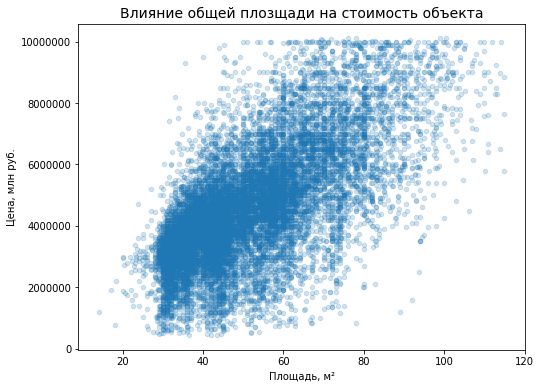

In [ ]:
data.plot(x='total_area', y='last_price', kind='scatter', figsize=(10, 6), alpha=0.2)
plt.title('Влияние общей плозщади на стоимость объекта', size=18)
plt.xlabel('Площадь, м²', size=14)
plt.ylabel('Цена, млн руб.', size=14)
plt.show()

Корреляция в 0.67 и график говорят о наличии зависимости, однако не слишком сильной. Выходит, что в какой-то степени увеличение цены зависит от общей площади.

##### Жилая площадь

In [ ]:
data['last_price'].corr(data['living_area'])

0.5469165578867289

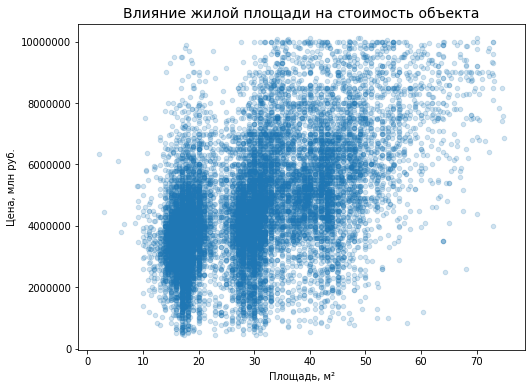

In [ ]:
data.plot(x='living_area', y='last_price', kind='scatter', figsize=(10, 6), alpha=0.2)
plt.title('Влияние жилой площади на стоимость объекта', size=18)
plt.xlabel('Площадь, м²', size=14)
plt.ylabel('Цена, млн руб.', size=14)
plt.show()

Корреляция в `0.55` и график говорят о наличии не очень сильной связи. Выходит, что рост жилой площади может сопровождаться увеличением цены, но так бывает не всегда.

##### Площадь кухни

In [ ]:
data['last_price'].corr(data['kitchen_area'])

0.45316766778593737

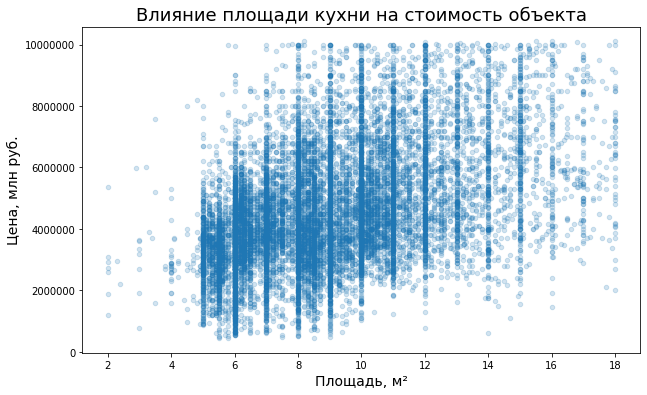

In [ ]:
data.plot(x='kitchen_area', y='last_price', kind='scatter', figsize=(10, 6), alpha=0.2)
plt.title('Влияние площади кухни на стоимость объекта', size=18)
plt.xlabel('Площадь, м²', size=14)
plt.ylabel('Цена, млн руб.', size=14)
plt.show()

Корреляция в `0.45` и график говорят о наличии слабой зависимости цены от площади кухни.

##### Количество комнат

In [ ]:
data['last_price'].corr(data['rooms'])

0.43050295529004573

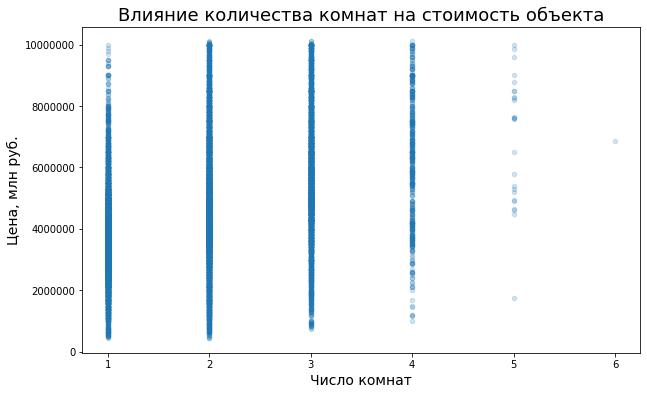

In [ ]:
data.plot(x='rooms', y='last_price', kind='scatter', figsize=(10, 6), alpha=0.2)
plt.title('Влияние количества комнат на стоимость объекта', size=18)
plt.xlabel('Число комнат', size=14)
plt.ylabel('Цена, млн руб.', size=14)
plt.show()

Корреляция в `0.43` и график демонстрируют слабую завимисоть между количеством комнат и стоимостью объекта.

##### Тип этажа

Считаю, что не совсем правильно рассчитывать зависимость типа этажа от общей стоимости, поэтому проанализируем зависимость между ценой кв. м. и типа этажа.

In [ ]:
pivot_table_floor_category = data.pivot_table(index='floor_category', values='price_square_meter', aggfunc=['count', 'median'])
pivot_table_floor_category.columns = ['count', 'median']
pivot_table_floor_category

,count,median
floor_category,,
другой,11614,"94,724.71"
первый,2011,"79,452.05"
последний,2148,"84,368.18"


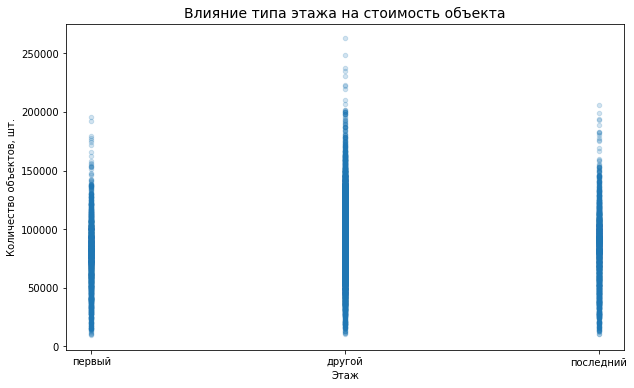

In [ ]:
data.plot(x='floor_category', y='price_square_meter', kind='scatter', figsize=(10, 6), alpha=0.2)
plt.title('Влияние типа этажа на стоимость объекта', size=18)
plt.xlabel('Этаж', size=14)
plt.ylabel('Количество объектов, шт.', size=14)
plt.show()

По графикам и медиане можно увидеть, что зависимость присутсвует, но она слабая. Самыми дешевыми являются объекты на 1-м этаже, дороже всего объекты с типом "другой".

##### Даты размещения

In [ ]:
data['last_price'].corr(data['day_exposition'])

-0.00812310518854272

,mean,count,median
day_exposition,,,
0,"4,598,927.52",2397,4300000
1,"4,591,143.21",2794,4300000
2,"4,621,494.28",2632,4300000
3,"4,618,165.81",2863,4300000
5,"4,566,145.46",1266,4300000
4,"4,596,136.81",2733,4225000
6,"4,508,504.71",1088,4200000


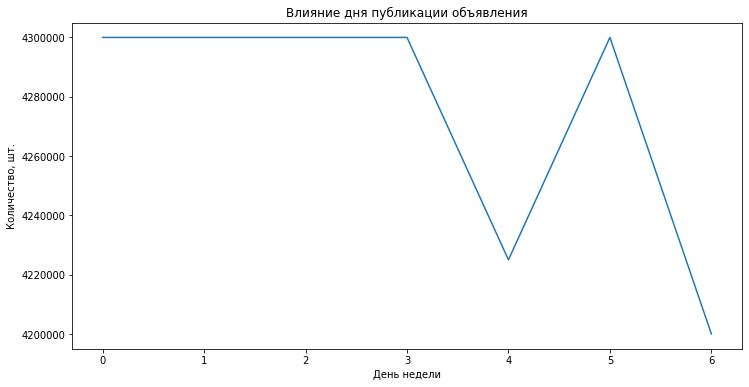

In [ ]:
pivot_table_day_exposition = data.pivot_table(index = 'day_exposition', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_day_exposition.columns = ['mean', 'count', 'median']
pivot_table_day_exposition.plot(title='Влияние дня публикации объявления', xlabel='День недели', ylabel='Количество, шт.', legend=False, y = 'median')
pivot_table_day_exposition.sort_values('median', ascending = False)

In [ ]:
data['last_price'].corr(data['month_exposition'])

0.008685198423254326

,mean,count,median
month_exposition,,,
6,"4,480,630.25",1309,4150000
10,"4,552,265.76",1558,4200000
3,"4,536,163.64",1502,4229000
7,"4,582,469.80",1205,4250000
5,"4,606,151.76",887,4299000
1,"4,614,553.58",928,4300000
2,"4,595,097.14",1732,4300000
4,"4,628,872.11",1201,4300000
8,"4,643,055.80",1263,4300000


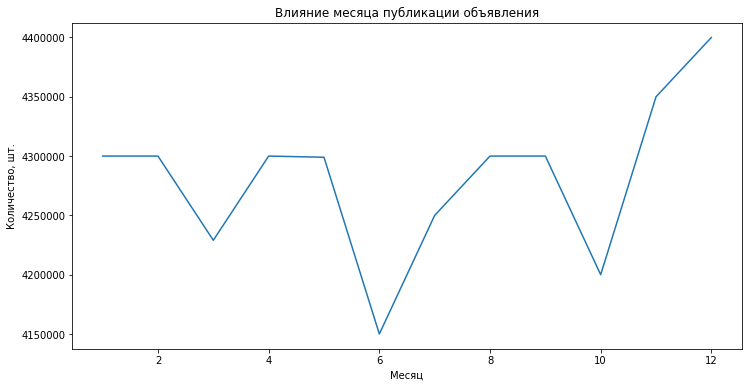

In [ ]:
pivot_table_month_exposition = data.pivot_table(index = 'month_exposition', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_month_exposition.columns = ['mean', 'count', 'median']
pivot_table_month_exposition.plot(title='Влияние месяца публикации объявления', xlabel='Месяц', ylabel='Количество, шт.', legend=False, y = 'median')
pivot_table_month_exposition.sort_values('median', ascending = True)

In [ ]:
data['last_price'].corr(data['year_exposition'])

0.0012001309447122815

,mean,count,median
year_exposition,,,
2014,"4,949,854.22",63,4600000
2019,"4,858,309.90",883,4550000
2015,"4,795,684.06",787,4500000
2018,"4,575,017.91",5709,4300000
2016,"4,563,082.98",2106,4200000
2017,"4,558,961.99",6225,4200000


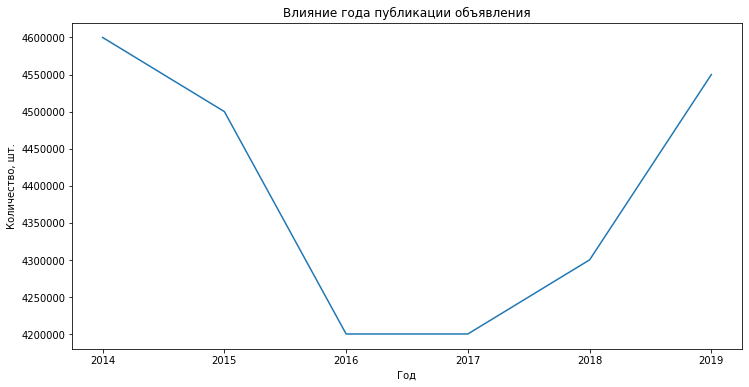

In [ ]:
pivot_table_month_exposition = data.pivot_table(index = 'year_exposition', values = 'last_price', aggfunc = ['mean', 'count', 'median'])
pivot_table_month_exposition.columns = ['mean', 'count', 'median']
pivot_table_month_exposition.plot(title='Влияние года публикации объявления', xlabel='Год', ylabel='Количество, шт.', legend=False, y = 'median')
pivot_table_month_exposition.sort_values('median', ascending = False)

In [ ]:
data[['day_exposition', 'month_exposition', 'year_exposition', 'last_price']].corr()

,day_exposition,month_exposition,year_exposition,last_price
day_exposition,1.00,0.00,0.00,-0.01
month_exposition,0.00,1.00,-0.17,0.01
year_exposition,0.00,-0.17,1.00,0.00
last_price,-0.01,0.01,0.00,1.00


Коэффициент корреляции практически равен `0`, что свидетельствует об отсутсвии влияния даты размещения объявления на цены недвижимости.

#### Средняя цена одного квадратного метра в 10 населенных пунктах с наибольшим количеством объявлений.

In [ ]:
top_ten_localities = data['locality_name'].value_counts().head(10)
top_ten_localities

Санкт-Петербург      10128
Мурино                 414
поселок Шушары         359
Кудрово                320
Всеволожск             291
Колпино                285
поселок Парголово      256
Гатчина                246
Пушкин                 243
Петергоф               162
Name: locality_name, dtype: int64

In [ ]:
top_ten_locality_names = list(top_ten_localities.index)

In [ ]:
(
    data.query('locality_name in @top_ten_locality_names')
    .pivot_table(index='locality_name', values='price_square_meter')
    .sort_values(by='price_square_meter', ascending=False)
)

,price_square_meter
locality_name,
Санкт-Петербург,"102,940.08"
Пушкин,"98,913.72"
Кудрово,"94,656.29"
поселок Парголово,"90,610.69"
Мурино,"85,504.89"
Петергоф,"82,157.82"
поселок Шушары,"77,767.64"
Колпино,"74,464.85"
Гатчина,"67,916.94"


В Санкт-Петербурге кв. м. стоит дороже всего и составляет `102940` руб., дешевле всего недвижимость обойдется во Всеволжске - `66598` руб. за кв. м. и Гатчине - `67917` руб. за кв. м. Однако, хотелось бы добавить, что в Пушкино (`98914` за кв. м.) и Кудрово (`94656` за кв. м.) недвижимость будет стоить не намного дешевле.

In [ ]:
data.groupby('locality_name').agg({'balcony':'count', 'last_price':'median'}) \
    .sort_values(by = 'balcony', ascending = False) \
    .head(10)

,balcony,last_price
locality_name,,
Санкт-Петербург,10128,4900000
Мурино,414,3500000
поселок Шушары,359,3900000
Кудрово,320,3800000
Всеволожск,291,3300000
Колпино,285,3500000
поселок Парголово,256,4050000
Гатчина,246,3000000
Пушкин,243,4650000


#### Влияние расположения объекта по отношению к центру

,mean,count,median
cityCenters_nearest_km,,,
0.00,"6,998,333.33",6,7050000
1.00,"7,498,912.26",57,7800000
2.00,"7,371,396.04",101,7500000
3.00,"6,548,213.64",154,6570000
4.00,"6,992,979.07",294,6912500
5.00,"6,855,010.19",369,6870000
6.00,"6,455,076.43",263,6350000
7.00,"6,140,625.80",202,6000000
8.00,"6,008,334.74",326,5789500


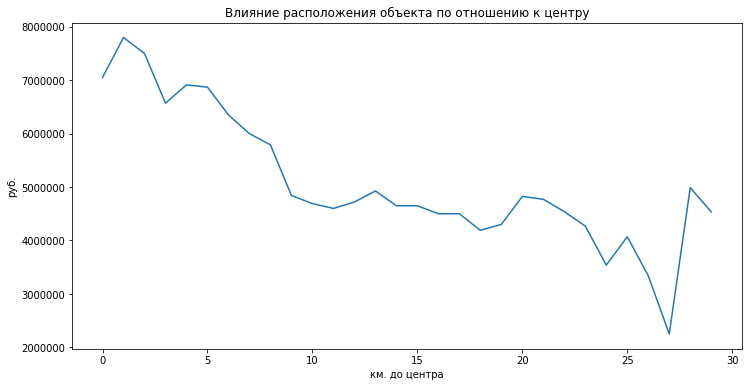

In [ ]:
spb_data = data.query('locality_name == "Санкт-Петербург"')
spb_km = spb_data.pivot_table(index='cityCenters_nearest_km', values='last_price', aggfunc=['mean', 'count', 'median'])
spb_km.columns = ['mean', 'count', 'median']
spb_km.plot(title='Влияние расположения объекта по отношению к центру', xlabel='км. до центра', ylabel='руб.', legend=False, y = 'median')
spb_km

Расположение объекта по отношению к центру влияет на цену, пик приходится на 0-3 км., далее идет небольшой спад вполть до 7 км., далее данный фактор перестает оказывать какое-либо влияние.

### Общий вывод

Перед тем как приступить к исследованию мы провели:
1. Предварительную обработку полученного архива данных - обработали пропущенные значения там, где это необходимо, заменили типы данных на необходимые для удобной работы.
2. Были определены и устранены аномальные значения в данных.
3. Посчитали и добавили в таблицу цену квадратного метра жилья, вывели из даты дни недели, месяцы и года размещения объявлений, добавили категории по этажам квартир и другие необходимые параметры.
4. В ходе анализа изучили  параметры на наличие выбивающихся значений и очистили данные от выбросов.

В ходе исследования были выявлены следующие факторы, влияющие больше всего на стоимость объекта:
1. Общая площадь;
2. Жилая площадь.

Цены на недвижимость зависят в первую очередь от данных факторов, в меньшей степени на нее влияет количество комнат. Остальные же факторы оказывают на формирование цены гораздо меньшее влияние.
Также мы выяснили, что объекты, которые продаются в течение 42 дней можно считать быстрыми продажами, а все продажи более 223 дней времени относятся к необычно долгим. В основном продажи занимают от 95 до 174 дней.

Недвижимость в центре Петербурга ожидаемо стоит дороже остальных населенных пунктов по области, а также цена кв. м. сильно зависит от расположения к центру (в ражиусе 7 км.), тем не менее чуть поодаль от центра цена за кв. м. примерно одинаковая.